### The COVID-19 pandemic is the defining global health crisis of our time and the greatest global humanitarian challenge the world has faced since World War II. The virus has spread widely, and the number of cases is rising daily as governments work to slow its spread. India has moved quickly, implementing a proactive, nationwide, lockdown, with the goal of flattening the curve and using the time to plan and resource responses adequately.

#### COVID-19 Timeline across the world 

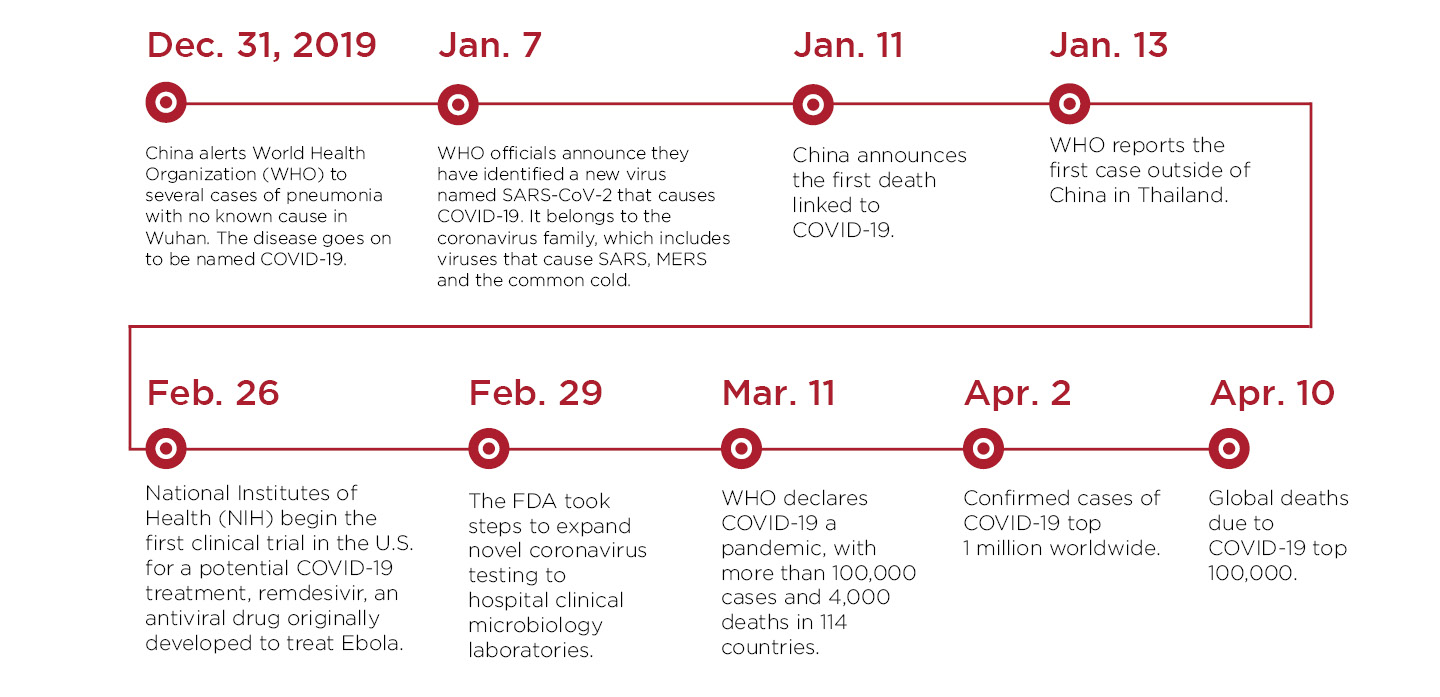

Import all required Libraries

In [109]:
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import seaborn as sns
import squarify
import plotly.offline as py
import plotly_express as px

from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot

from IPython.display import Image
warnings.filterwarnings('ignore')
%matplotlib inline



Read all input files

In [110]:
age_details = pd.read_csv('AgeGroupDetails.csv')
india_covid_19 = pd.read_csv('covid_19_india.csv')
hospital_beds = pd.read_csv('HospitalBedsIndia.csv')
individual_details = pd.read_csv('IndividualDetails.csv')
ICMR_labs = pd.read_csv('ICMRTestingLabs.csv')
state_testing = pd.read_csv('StatewiseTestingDetails.csv')
population = pd.read_csv('population_india_census2011.csv')

world_population = pd.read_csv('population_by_country_2020.csv')


#Data from 2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE

confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovered_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/04-04-2020.csv')

Have a look on all dataframes for proper understanding

In [3]:
age_details.head(2)

,Sno,AgeGroup,TotalCases,Percentage
0,1,0-9,22,3.18%
1,2,10-19,27,3.90%


In [4]:
india_covid_19.head(2)


,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
0,1,30/01/20,6:00 PM,Kerala,1,0,0,0,1
1,2,31/01/20,6:00 PM,Kerala,1,0,0,0,1


In [5]:
india_covid_19['Date'] = pd.to_datetime(india_covid_19['Date'],dayfirst = True)
india_covid_19.head(2)

,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
0,1,2020-01-30,6:00 PM,Kerala,1,0,0,0,1
1,2,2020-01-31,6:00 PM,Kerala,1,0,0,0,1


In [33]:
hospital_beds.head(2)

,Sno,State/UT,NumPrimaryHealthCenters_HMIS,NumCommunityHealthCenters_HMIS,NumSubDistrictHospitals_HMIS,NumDistrictHospitals_HMIS,TotalPublicHealthFacilities_HMIS,NumPublicBeds_HMIS,NumRuralHospitals_NHP18,NumRuralBeds_NHP18,NumUrbanHospitals_NHP18,NumUrbanBeds_NHP18
0,1,Andaman & Nicobar Islands,27,4,NaN,3,34,1246,27,575,3,500
1,2,Andhra Pradesh,1417,198,31.0,20,1666,60799,193,6480,65,16658


In [34]:
hospital_beds.dtypes

Sno                                   int64
State/UT                             object
NumPrimaryHealthCenters_HMIS          int64
NumCommunityHealthCenters_HMIS        int64
NumSubDistrictHospitals_HMIS        float64
NumDistrictHospitals_HMIS             int64
TotalPublicHealthFacilities_HMIS      int64
NumPublicBeds_HMIS                    int64
NumRuralHospitals_NHP18               int64
NumRuralBeds_NHP18                    int64
NumUrbanHospitals_NHP18               int64
NumUrbanBeds_NHP18                    int64
dtype: object

In [7]:
individual_details.head(2)

,id,government_id,diagnosed_date,age,gender,detected_city,detected_district,detected_state,nationality,current_status,status_change_date,notes
0,0,KL-TS-P1,30/01/2020,20,F,Thrissur,Thrissur,Kerala,India,Recovered,14/02/2020,Travelled from Wuhan
1,1,KL-AL-P1,02/02/2020,NaN,NaN,Alappuzha,Alappuzha,Kerala,India,Recovered,14/02/2020,Travelled from Wuhan


In [8]:
ICMR_labs.head(2)

,lab,address,pincode,city,state,type
0,"ICMR-Regional Medical Research Centre, Port Blair","ICMR-Regional Medical Research Centre, Post Ba...",744103,Port Blair,Andaman and Nicobar Islands,Government Laboratory
1,Tomo Riba Institute of Health & Medical Scienc...,"National Highway 52A, Old Assembly Complex, Na...",791110,Naharlagun,Arunachal Pradesh,Collection Site


In [9]:
state_testing.head(2)

,Date,State,TotalSamples,Negative,Positive
0,2020-04-17,Andaman and Nicobar Islands,1403.0,1210,12.0
1,2020-04-24,Andaman and Nicobar Islands,2679.0,NaN,27.0


In [10]:
state_testing['Date'] = pd.to_datetime(state_testing['Date'])
state_testing.head(2)

,Date,State,TotalSamples,Negative,Positive
0,2020-04-17,Andaman and Nicobar Islands,1403.0,1210,12.0
1,2020-04-24,Andaman and Nicobar Islands,2679.0,NaN,27.0


In [11]:
population.head(2)

,Sno,State / Union Territory,Population,Rural population,Urban population,Area,Density,Gender Ratio
0,1,Uttar Pradesh,199812341,155317278,44495063,"240,928 km2 (93,023 sq mi)","828/km2 (2,140/sq mi)",912
1,2,Maharashtra,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929


In [12]:
world_population.head(2)

,Country (or dependency),Population (2020),Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (net),Fert. Rate,Med. Age,Urban Pop %,World Share
0,China,1438207241,0.39 %,5540090,153,9388211,-348399.0,1.7,38,61 %,18.47 %
1,India,1377233523,0.99 %,13586631,464,2973190,-532687.0,2.2,28,35 %,17.70 %


In [13]:
confirmed_df.head(10)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,35301,35475,35526,35615,35727,35928,35981,36036,36157,36263
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,4008,4090,4171,4290,4358,4466,4570,4637,4763,4880
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,22549,23084,23691,24278,24872,25484,26159,26764,27357,27973
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,880,880,884,884,889,889,897,897,897,907
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,687,705,749,779,812,851,880,916,932,950
5,NaN,Antigua and Barbuda,17.06080,-61.796400,0,0,0,0,0,0,...,76,76,76,76,76,76,82,82,82,86
6,NaN,Argentina,-38.41610,-63.616700,0,0,0,0,0,0,...,122524,126755,130774,136118,141900,148027,153520,158334,162526,167416
7,NaN,Armenia,40.06910,45.038200,0,0,0,0,0,0,...,34462,34877,34981,35254,35693,36162,36613,36996,37317,37390
8,Australian Capital Territory,Australia,-35.47350,149.012400,0,0,0,0,0,0,...,113,113,113,113,113,113,113,113,113,113
9,New South Wales,Australia,-33.86880,151.209300,0,0,0,0,3,4,...,3568,3588,3599,3614,3633,3640,3654,3668,3685,3699


In [14]:
deaths_df.head(2)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,1164,1181,1185,1186,1190,1211,1225,1248,1259,1269
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,111,112,113,117,120,123,128,134,138,144


In [15]:
recovered_df.head(2)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,23273,23634,23741,23741,23924,24550,24602,24793,25180,25198
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,2264,2311,2352,2397,2463,2523,2608,2637,2682,2745


In [16]:
latest_data.head(2)

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
0,45001.0,Abbeville,South Carolina,US,4/4/20 23:34,34.223334,-82.461707,6,0,0,0,"Abbeville, South Carolina, US"
1,22001.0,Acadia,Louisiana,US,4/4/20 23:34,30.295065,-92.414197,65,2,0,0,"Acadia, Louisiana, US"


# World Updates

THE FOLLOWING DATA IS TILL 7/27/20
Confirmed cases = 16481230
Active cases = 6254559
Recoverd cases = 9572619
Deceased cases = 654052


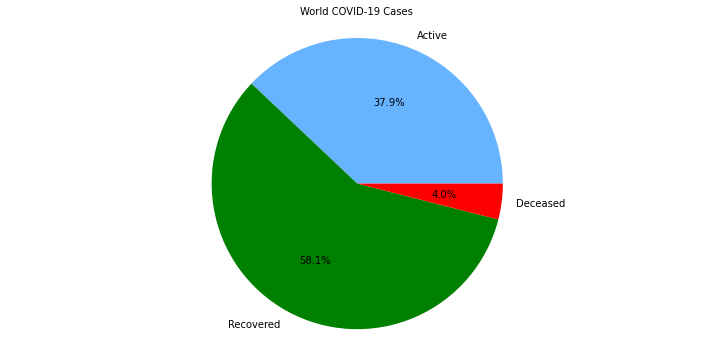

In [17]:
world_confirmed = confirmed_df[confirmed_df.columns[-1]].sum()
world_recovered = recovered_df[recovered_df.columns[-1]].sum()
world_deaths = deaths_df[deaths_df.columns[-1]].sum()
world_active = world_confirmed - world_recovered - world_deaths

Date =confirmed_df.columns[-1]
print("THE FOLLOWING DATA IS TILL",Date)


print('Confirmed cases =', world_confirmed)
print('Active cases =', world_active)
print('Recoverd cases =', world_recovered)
print('Deceased cases =', world_deaths)

labels = ['Active','Recovered','Deceased']
sizes = [world_active,world_recovered,world_deaths]
color= ['#66b3ff','green','red']
explode = []

for i in labels:
    explode.append(0)
    
plt.figure(figsize= (10,5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', explode =explode,colors = color)
#centre_circle = plt.Circle((0,0),0.30,fc='white')

fig = plt.gcf()
#fig.gca().add_artist(centre_circle)
plt.title('World COVID-19 Cases',fontsize = 10)
plt.axis('equal')  
plt.tight_layout()

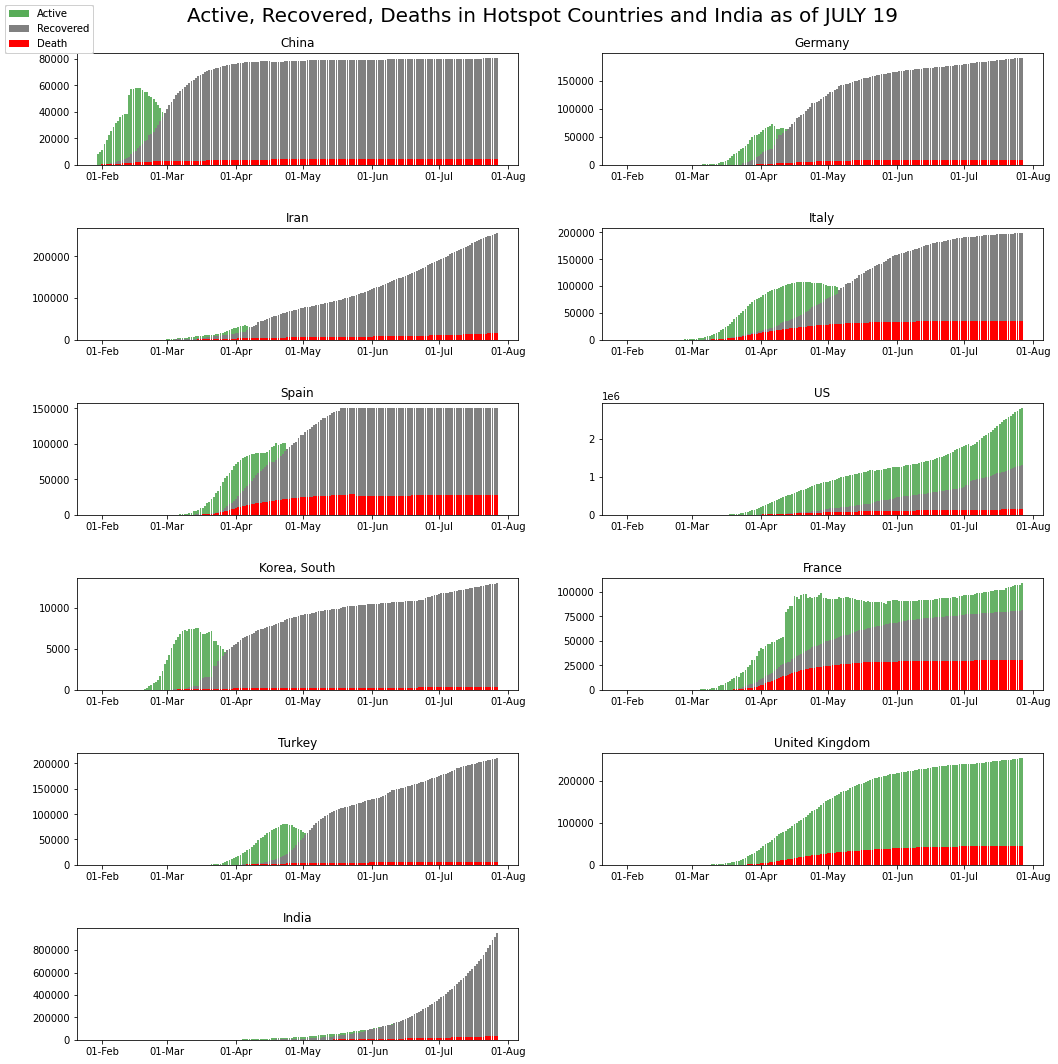

In [18]:
hotspots = ['China','Germany','Iran','Italy','Spain','US','Korea, South','France','Turkey','United Kingdom','India']
dates = list(confirmed_df.columns[4:])
dates = list(pd.to_datetime(dates))
dates_india = dates[8:]

df1 = confirmed_df.groupby('Country/Region').sum().reset_index()
df2 = deaths_df.groupby('Country/Region').sum().reset_index()
df3 = recovered_df.groupby('Country/Region').sum().reset_index()

global_confirmed = {}
global_deaths = {}
global_recovered = {}
global_active= {}

for country in hotspots:
    k =df1[df1['Country/Region'] == country].loc[:,'1/30/20':]
    global_confirmed[country] = k.values.tolist()[0]

    k =df2[df2['Country/Region'] == country].loc[:,'1/30/20':]
    global_deaths[country] = k.values.tolist()[0]

    k =df3[df3['Country/Region'] == country].loc[:,'1/30/20':]
    global_recovered[country] = k.values.tolist()[0]
    
for country in hotspots:
    k = list(map(int.__sub__, global_confirmed[country], global_deaths[country]))
    global_active[country] = list(map(int.__sub__, k, global_recovered[country]))
    
fig = plt.figure(figsize= (15,15))
plt.suptitle('Active, Recovered, Deaths in Hotspot Countries and India as of JULY 19',fontsize = 20,y=1.0)
#plt.legend()
k=0
for i in range(1,12):
    ax = fig.add_subplot(6,2,i)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    ax.bar(dates_india,global_active[hotspots[k]],color = 'green',alpha = 0.6,label = 'Active');
    ax.bar(dates_india,global_recovered[hotspots[k]],color='grey',label = 'Recovered');
    ax.bar(dates_india,global_deaths[hotspots[k]],color='red',label = 'Death');   
    plt.title(hotspots[k])
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper left')
    k=k+1

plt.tight_layout(pad=3.0)

We can see certain recovery in contries like South Korea , Italy, Turkey 

and increase in active cases in contries like US , INDIA , United Kingdom

## INDIA UPDATES

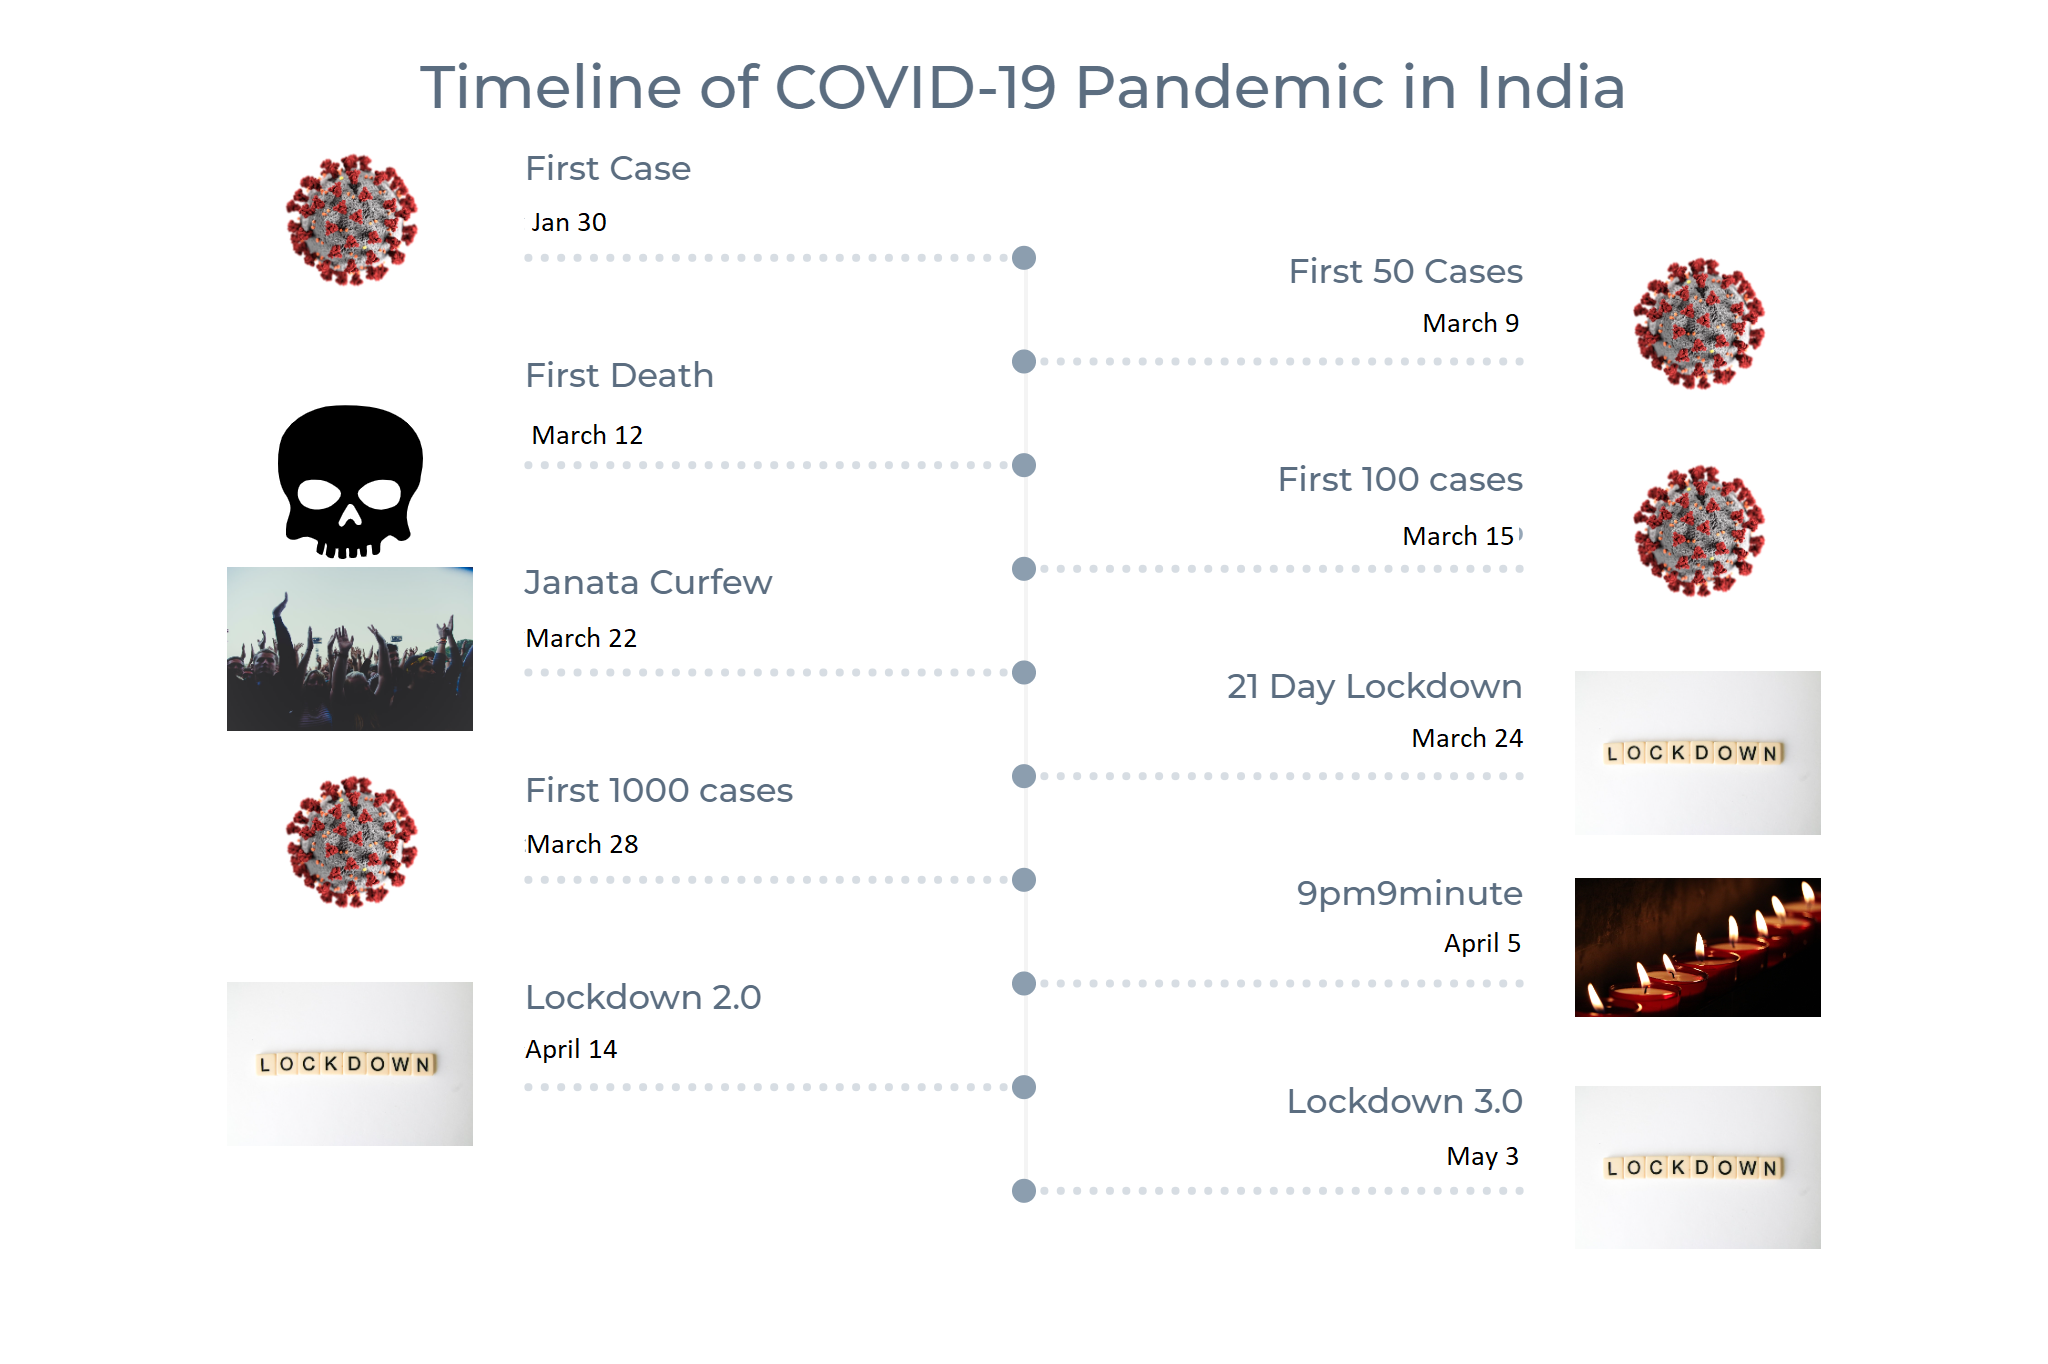

Age group analysis

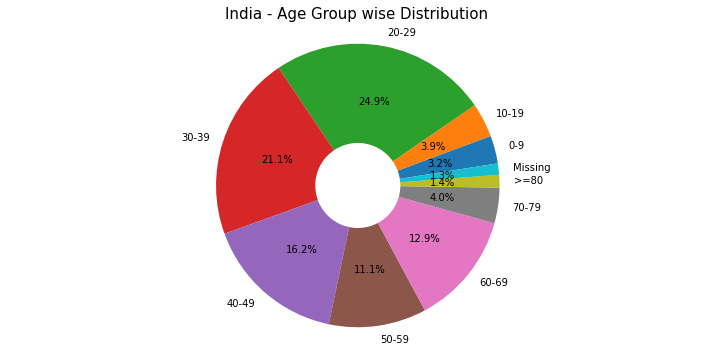

In [19]:
labels = list(age_details['AgeGroup'])
sizes = list(age_details['TotalCases'])

explode = []

for i in labels:
    explode.append(0)
    
plt.figure(figsize= (10,5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=9, explode =explode)
centre_circle = plt.Circle((0,0),0.30,fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('India - Age Group wise Distribution',fontsize = 15)
plt.axis('equal')  
plt.tight_layout()

From this pie chart we see that people < 50 years are majorly affected which is apposite to the saying that "erderly people(>60 yrs) are more affected from COVID-19."

### Gender Analysis 

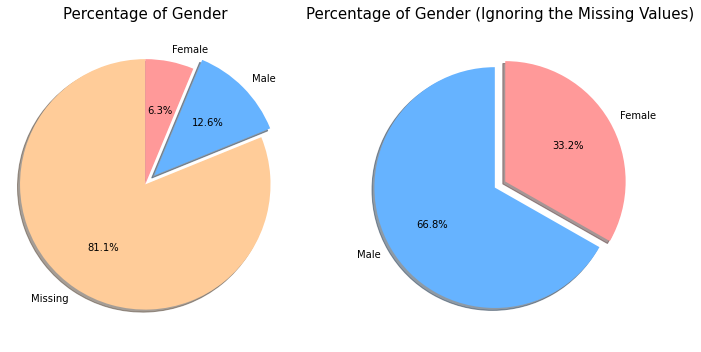

In [20]:
labels = ['Missing', 'Male', 'Female']
sizes = []
sizes.append(individual_details['gender'].isnull().sum())
sizes.append(list(individual_details['gender'].value_counts())[0])
sizes.append(list(individual_details['gender'].value_counts())[1])
fig = plt.figure(figsize= (10,5))
explode = (0, 0.1, 0)
colors = ['#ffcc99','#66b3ff','#ff9999']
ax=fig.add_subplot(1,2,1)
#plt.figure(figsize= (10,5))
plt.title('Percentage of Gender',fontsize = 15)
ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',shadow=True, startangle=90)
ax.axis('equal')
#plt.tight_layout()

labels = ['Male', 'Female']
sizes = []
sizes.append(list(individual_details['gender'].value_counts())[0])
sizes.append(list(individual_details['gender'].value_counts())[1])
ax=fig.add_subplot(1,2,2)
explode = (0.1, 0)
colors = ['#66b3ff','#ff9999']

#plt.figure(figsize= (10,5))
ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)

plt.title('Percentage of Gender (Ignoring the Missing Values)',fontsize = 15)
ax.axis('equal')
plt.tight_layout()

Men are the most affected accounting to 67%. But, remember we have ~81% data missing.

In [21]:
dates = list(confirmed_df.columns[4:])
dates = list(pd.to_datetime(dates))
dates_india = dates[8:]

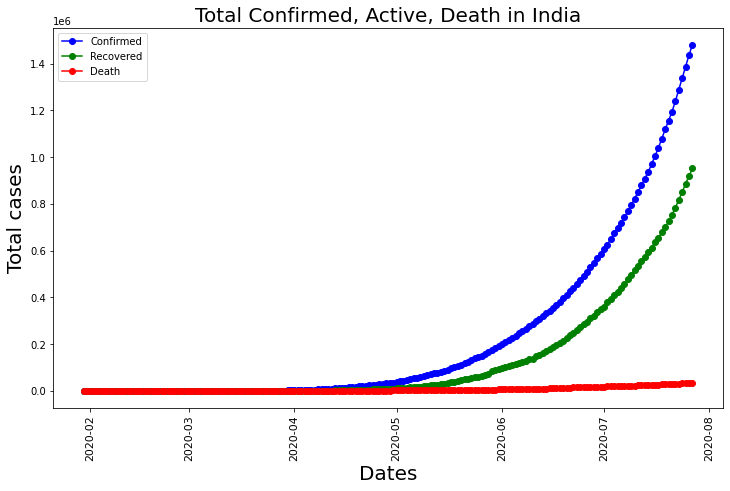

In [22]:
df1 = confirmed_df.groupby('Country/Region').sum().reset_index()
df2 = deaths_df.groupby('Country/Region').sum().reset_index()
df3 = recovered_df.groupby('Country/Region').sum().reset_index()

k = df1[df1['Country/Region']=='India'].loc[:,'1/30/20':]
india_confirmed = k.values.tolist()[0] 

k = df2[df2['Country/Region']=='India'].loc[:,'1/30/20':]
india_deaths = k.values.tolist()[0] 

k = df3[df3['Country/Region']=='India'].loc[:,'1/30/20':]
india_recovered = k.values.tolist()[0] 

plt.figure(figsize= (12,7))
plt.xticks(rotation = 90 ,fontsize = 11)
plt.yticks(fontsize = 10)
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Total Confirmed, Active, Death in India" , fontsize = 20)

ax1 = plt.plot_date(y= india_confirmed,x= dates_india,label = 'Confirmed',linestyle ='-',color = 'b')
ax2 = plt.plot_date(y= india_recovered,x= dates_india,label = 'Recovered',linestyle ='-',color = 'g')
ax3 = plt.plot_date(y= india_deaths,x= dates_india,label = 'Death',linestyle ='-',color = 'r')
plt.legend();

### Comparison with some other countries  

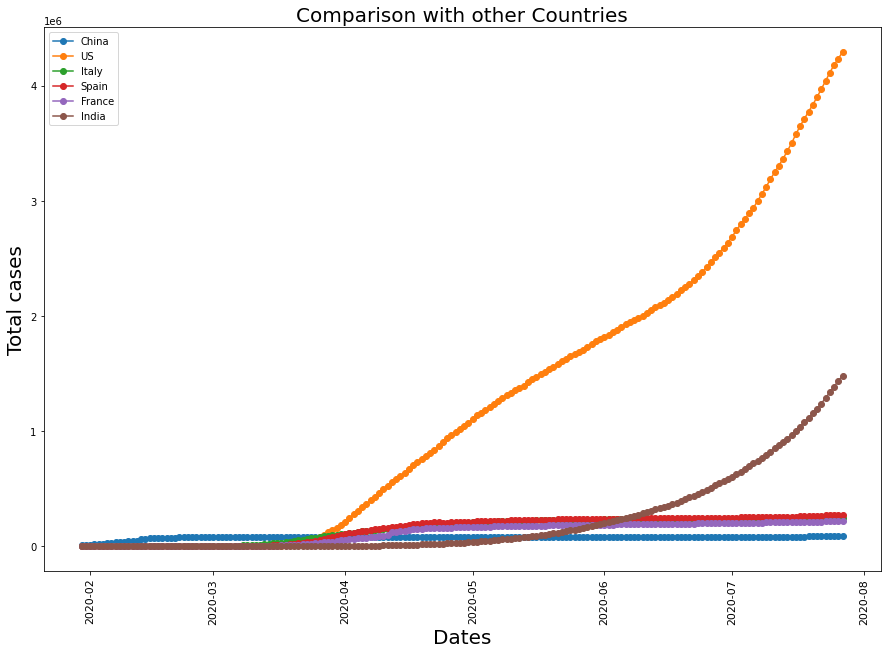

In [23]:
countries = ['China','US', 'Italy', 'Spain', 'France','India']

global_confirmed = []
global_recovered = []
global_deaths = []
global_active = []

for country in countries:
    k =df1[df1['Country/Region'] == country].loc[:,'1/30/20':]
    global_confirmed.append(k.values.tolist()[0]) 

    k =df2[df2['Country/Region'] == country].loc[:,'1/30/20':]
    global_deaths.append(k.values.tolist()[0]) 

    k =df3[df3['Country/Region'] == country].loc[:,'1/30/20':]
    global_deaths.append(k.values.tolist()[0])  

plt.figure(figsize= (15,10))
plt.xticks(rotation = 90 ,fontsize = 11)
plt.yticks(fontsize = 10)
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Comparison with other Countries" , fontsize = 20)

for i in range(len(countries)):
    plt.plot_date(y= global_confirmed[i],x= dates_india,label = countries[i],linestyle ='-')
plt.legend();

# STATE WISE VISUALIZATION

In [24]:
state_cases = india_covid_19.groupby('State/UnionTerritory')['Confirmed','Deaths','Cured'].max().reset_index()

#state_cases = state_cases.astype({'Deaths': 'int'})
state_cases['Active'] = state_cases['Confirmed'] - (state_cases['Deaths']+state_cases['Cured'])
state_cases["Death Rate (per 100)"] = np.round(100*state_cases["Deaths"]/state_cases["Confirmed"],2)
state_cases["Cure Rate (per 100)"] = np.round(100*state_cases["Cured"]/state_cases["Confirmed"],2)
state_cases.sort_values('Confirmed', ascending= False).fillna(0).style.background_gradient(cmap='Blues',subset=["Confirmed"])\
                        .background_gradient(cmap='Blues',subset=["Deaths"])\
                        .background_gradient(cmap='Blues',subset=["Cured"])\
                        .background_gradient(cmap='Blues',subset=["Active"])\
                        .background_gradient(cmap='Blues',subset=["Death Rate (per 100)"])\
                        .background_gradient(cmap='Blues',subset=["Cure Rate (per 100)"])


,State/UnionTerritory,Confirmed,Deaths,Cured,Active,Death Rate (per 100),Cure Rate (per 100)
22,Maharashtra,292589,11452,160357,120780,3.910000,54.810000
32,Tamil Nadu,160907,2315,110807,47785,1.440000,68.860000
11,Delhi,120107,3571,99301,17235,2.970000,82.680000
18,Karnataka,55115,1147,20757,33211,2.080000,37.660000
13,Gujarat,46430,2106,32973,11351,4.540000,71.020000
37,Uttar Pradesh,45163,1084,27634,16445,2.400000,61.190000
33,Telangana,42496,403,28705,13388,0.950000,67.550000
1,Andhra Pradesh,40646,534,20298,19814,1.310000,49.940000
39,West Bengal,38011,1049,22253,14709,2.760000,58.540000
30,Rajasthan,27789,546,20626,6617,1.960000,74.220000


### Analysis the 5 day MA  

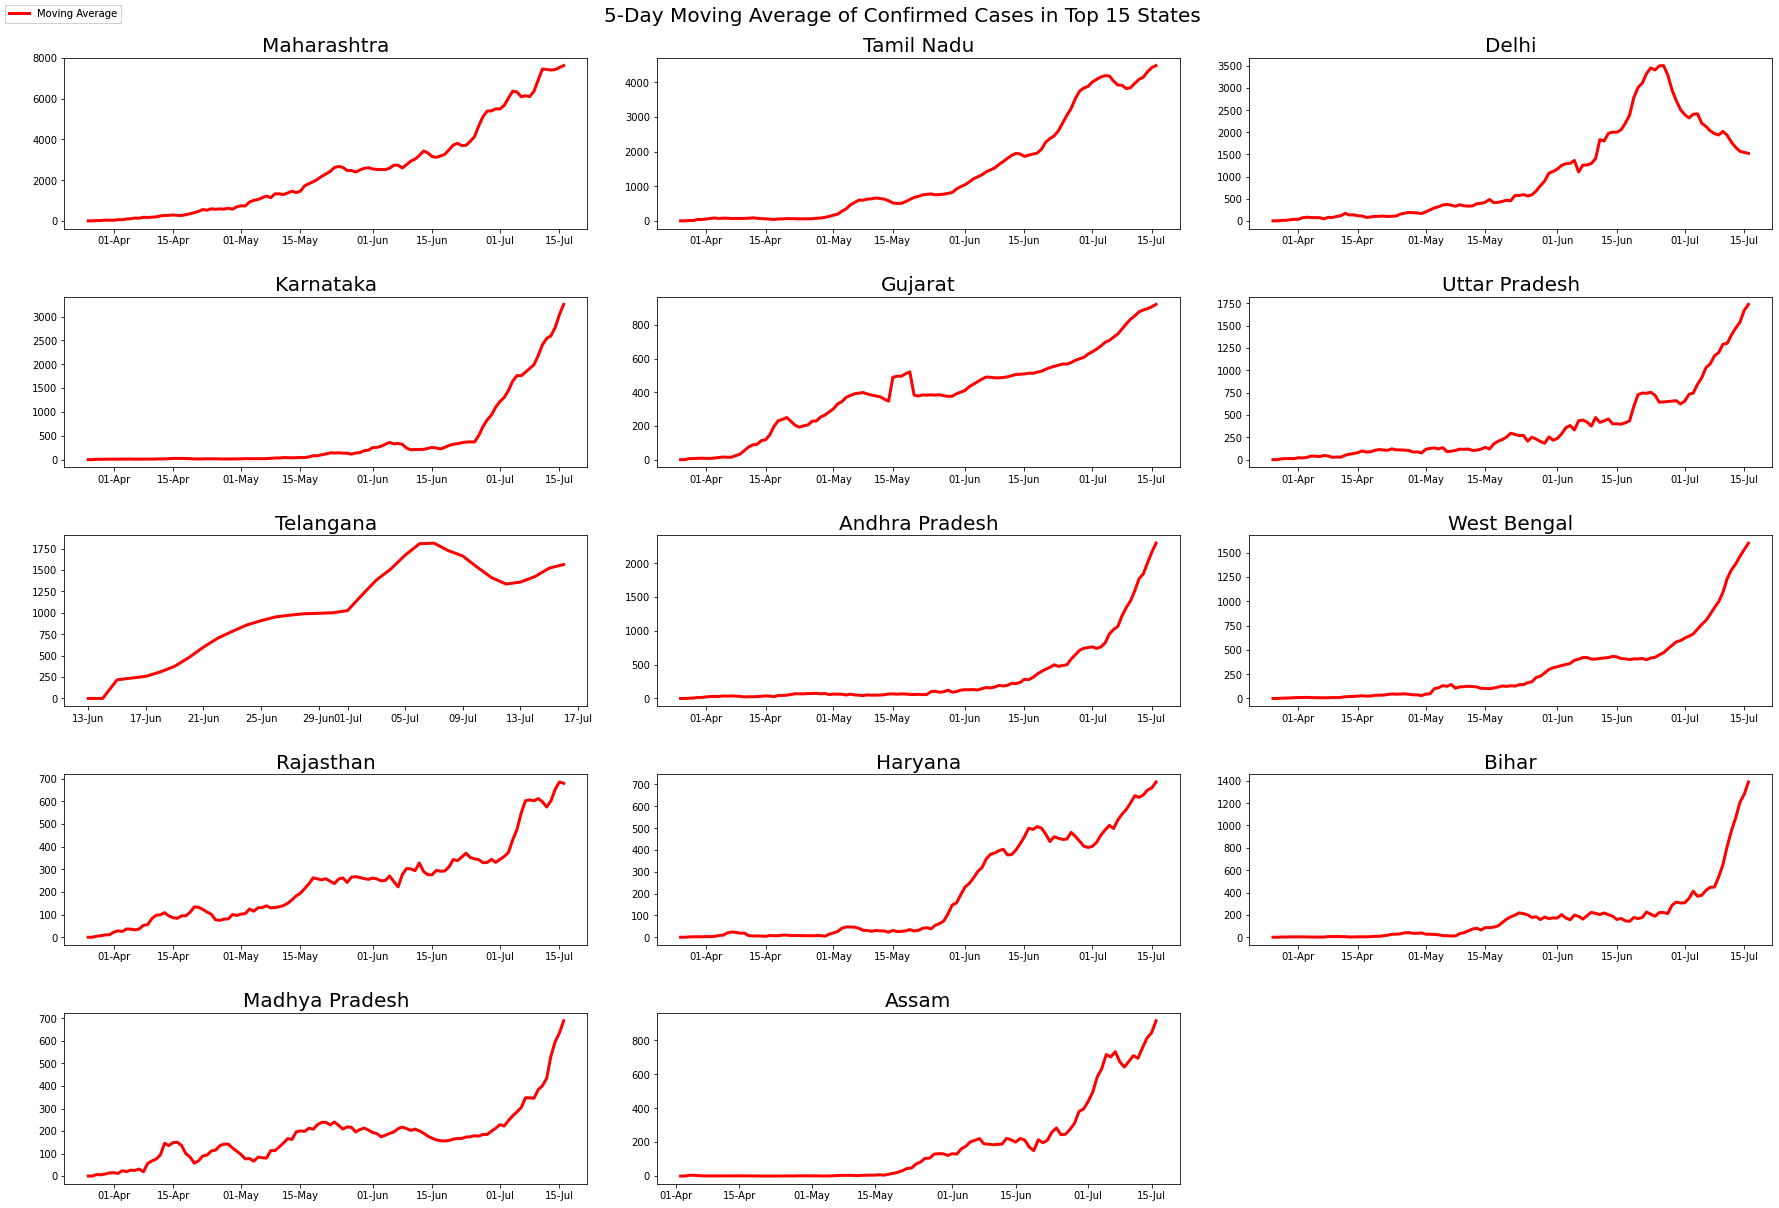

In [25]:
all_state = list(india_covid_19['State/UnionTerritory'].unique())
all_state.remove('Unassigned')
#all_state.remove('Nagaland#')
#all_state.remove('Nagaland')
latest = india_covid_19[india_covid_19['Date'] > '24-03-20']
state_cases = latest.groupby('State/UnionTerritory')['Confirmed','Deaths','Cured'].max().reset_index()
latest['Active'] = latest['Confirmed'] - (latest['Deaths']- latest['Cured'])
state_cases = state_cases.sort_values('Confirmed', ascending= False).fillna(0)
states =list(state_cases['State/UnionTerritory'][0:15])

states_confirmed = {}
states_deaths = {}
states_recovered = {}
states_active = {}
states_dates = {}

for state in states:
    df = latest[latest['State/UnionTerritory'] == state].reset_index()
    k = []
    l = []
    m = []
    n = []
    for i in range(1,len(df)):
        k.append(df['Confirmed'][i]-df['Confirmed'][i-1])
        l.append(df['Deaths'][i]-df['Deaths'][i-1])
        m.append(df['Cured'][i]-df['Cured'][i-1])
        n.append(df['Active'][i]-df['Active'][i-1])
    states_confirmed[state] = k
    states_deaths[state] = l
    states_recovered[state] = m
    states_active[state] = n
    date = list(df['Date'])
    states_dates[state] = date[1:]
    
def calc_movingaverage(values ,N):    
    cumsum, moving_aves = [0], [0,0]
    for i, x in enumerate(values, 1):
        cumsum.append(cumsum[i-1] + x)
        if i>=N:
            moving_ave = (cumsum[i] - cumsum[i-N])/N
            moving_aves.append(moving_ave)
    return moving_aves

fig = plt.figure(figsize= (25,17))
plt.suptitle('5-Day Moving Average of Confirmed Cases in Top 15 States',fontsize = 20,y=1.0)
k=0
for i in range(1,15):
    ax = fig.add_subplot(5,3,i)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    #ax.bar(states_dates[states[k]],states_confirmed[states[k]],label = 'Day wise Confirmed Cases ') 
    moving_aves = calc_movingaverage(states_confirmed[states[k]],5)
    ax.plot(states_dates[states[k]][:-2],moving_aves,color='red',label = 'Moving Average',linewidth =3)  
    plt.title(states[k],fontsize = 20)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper left')
    k=k+1
plt.tight_layout(pad=3.0)

The 5 Day Moving Average helps to identify the on general which states are recovering and in which states cases are increasing day by day.

### Health care facilites present in our Country 

In [42]:
hospital_beds =hospital_beds.drop([36])

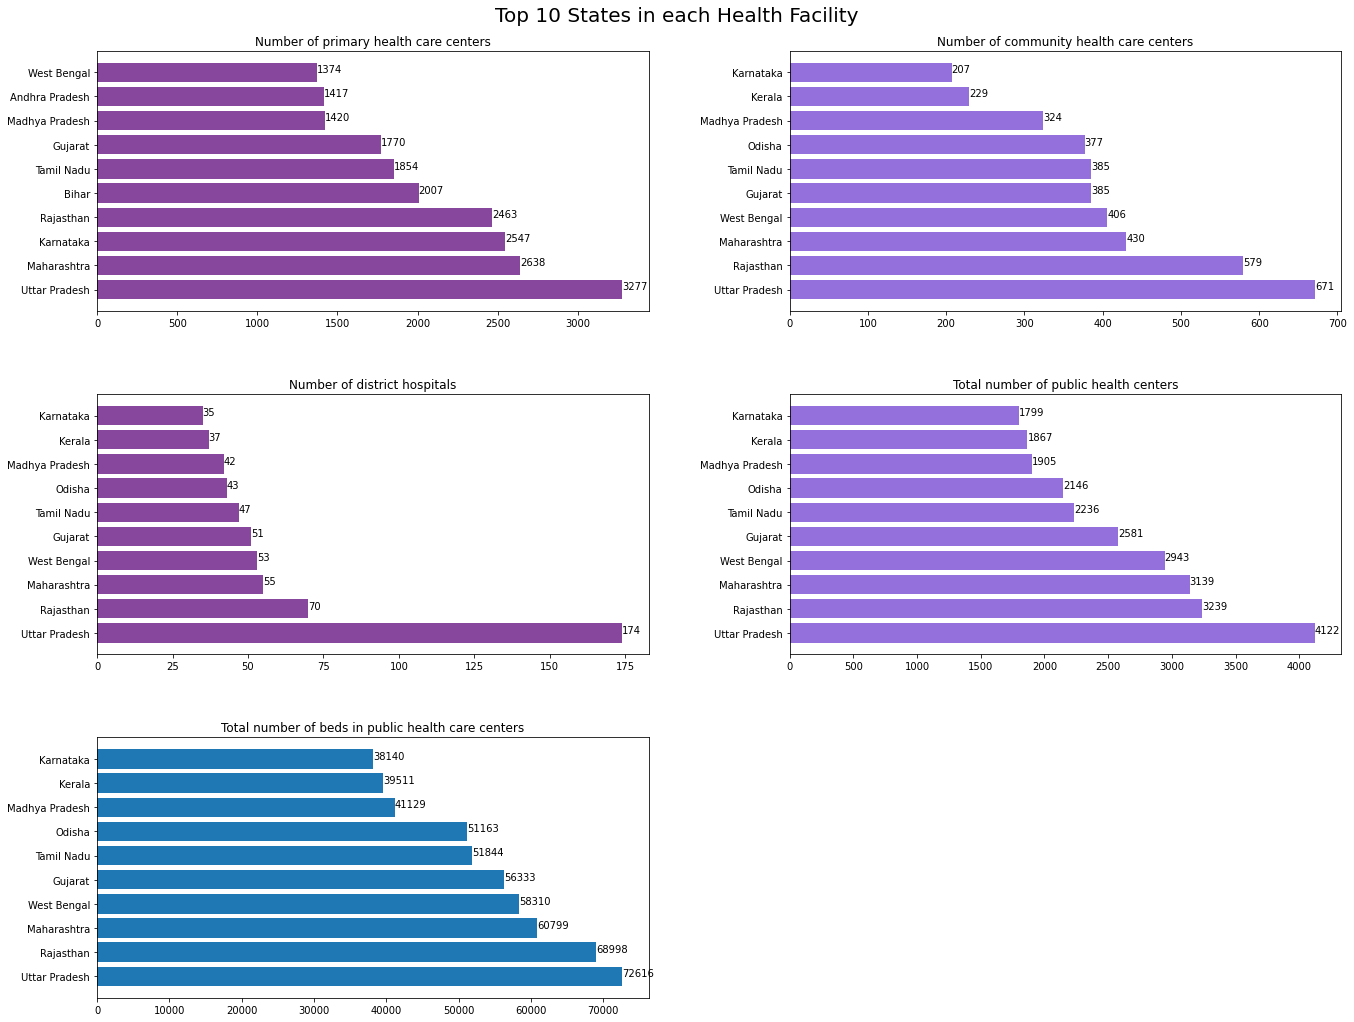

In [71]:


    
top_10_primary = hospital_beds.nlargest(10,'NumPrimaryHealthCenters_HMIS')
top_10_community = hospital_beds.nlargest(10,'NumCommunityHealthCenters_HMIS')
top_10_district_hospitals = hospital_beds.nlargest(10,'NumDistrictHospitals_HMIS')
top_10_public_facility = hospital_beds.nlargest(10,'TotalPublicHealthFacilities_HMIS')
top_10_public_beds = hospital_beds.nlargest(10,'NumPublicBeds_HMIS')

plt.figure(figsize=(20,15))
plt.suptitle('Top 10 States in each Health Facility',fontsize=20)
plt.subplot(321)
plt.title('Number of primary health care centers')
plt.barh(top_10_primary['State/UT'],top_10_primary['NumPrimaryHealthCenters_HMIS'],color ='#87479d')
for index, value in enumerate(top_10_primary['NumPrimaryHealthCenters_HMIS']):
    plt.text(value, index, str(value))

plt.subplot(322)
plt.title('Number of community health care centers')
plt.barh(top_10_community['State/UT'],top_10_community['NumCommunityHealthCenters_HMIS'],color = '#9370db')
for index, value in enumerate(top_10_community['NumCommunityHealthCenters_HMIS']):
    plt.text(value, index, str(value))

plt.subplot(324)
plt.title('Total number of public health centers')
plt.barh(top_10_community['State/UT'],top_10_public_facility['TotalPublicHealthFacilities_HMIS'],color='#9370db')
for index, value in enumerate(top_10_public_facility['TotalPublicHealthFacilities_HMIS']):
    plt.text(value, index, str(value))

plt.subplot(323)
plt.title('Number of district hospitals')
plt.barh(top_10_community['State/UT'],top_10_district_hospitals['NumDistrictHospitals_HMIS'],color = '#87479d')
for index, value in enumerate(top_10_district_hospitals['NumDistrictHospitals_HMIS']):
    plt.text(value, index, str(value))
    
plt.subplot(325)
plt.title('Total number of beds in public health care centers')
plt.barh(top_10_community['State/UT'],top_10_public_beds['NumPublicBeds_HMIS']);
for index, value in enumerate(top_10_public_beds['NumPublicBeds_HMIS']):
    plt.text(value, index, str(value))
    
    
    
    
plt.tight_layout(pad=5) 

### Beds available for covid pateints in rural and urban area 

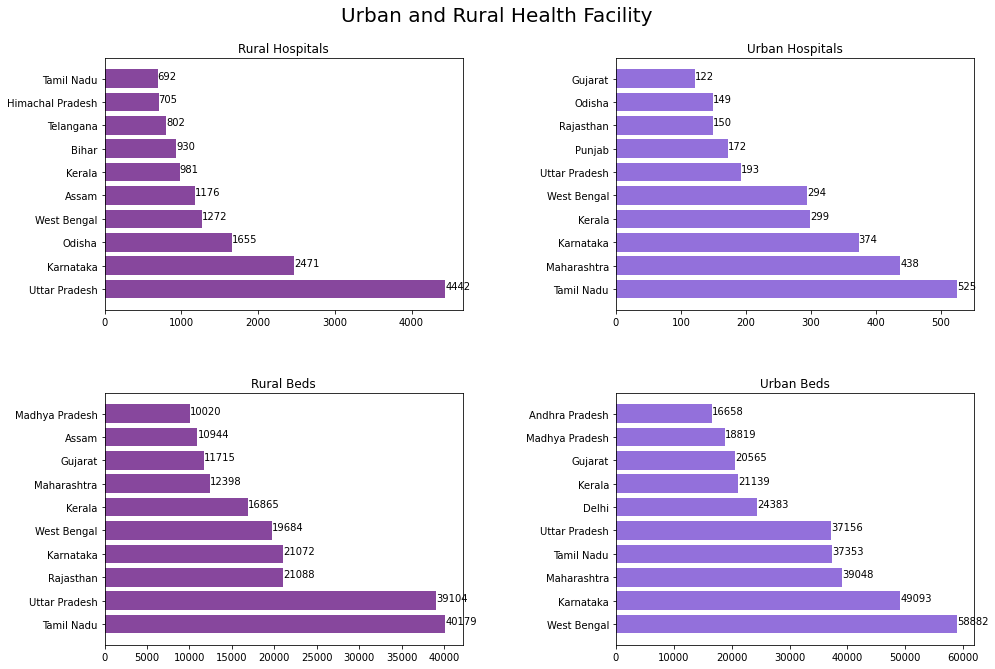

In [72]:
top_rural_hos = hospital_beds.nlargest(10,'NumRuralHospitals_NHP18')
top_rural_beds = hospital_beds.nlargest(10,'NumRuralBeds_NHP18')
top_urban_hos = hospital_beds.nlargest(10,'NumUrbanHospitals_NHP18')
top_urban_beds = hospital_beds.nlargest(10,'NumUrbanBeds_NHP18')

plt.figure(figsize=(15,10))
plt.suptitle('Urban and Rural Health Facility',fontsize=20)
plt.subplot(221)
plt.title('Rural Hospitals')
plt.barh(top_rural_hos['State/UT'],top_rural_hos['NumRuralHospitals_NHP18'],color = '#87479d')
for index, value in enumerate(top_rural_hos['NumRuralHospitals_NHP18']):
    plt.text(value, index, str(value))

plt.subplot(222)
plt.title('Urban Hospitals')
plt.barh(top_urban_hos['State/UT'],top_urban_hos['NumUrbanHospitals_NHP18'],color = '#9370db')
for index, value in enumerate(top_urban_hos['NumUrbanHospitals_NHP18']):
    plt.text(value, index, str(value))
    
plt.subplot(223)
plt.title('Rural Beds')
plt.barh(top_rural_beds['State/UT'],top_rural_beds['NumRuralBeds_NHP18'],color = '#87479d')
for index, value in enumerate(top_rural_beds['NumRuralBeds_NHP18']):
    plt.text(value, index, str(value))
    
plt.subplot(224)
plt.title('Urban Beds')
plt.barh(top_urban_beds['State/UT'],top_urban_beds['NumUrbanBeds_NHP18'],color = '#9370db');
for index, value in enumerate(top_urban_beds['NumUrbanBeds_NHP18']):
    plt.text(value, index, str(value))
    
    
plt.tight_layout(pad=5)     

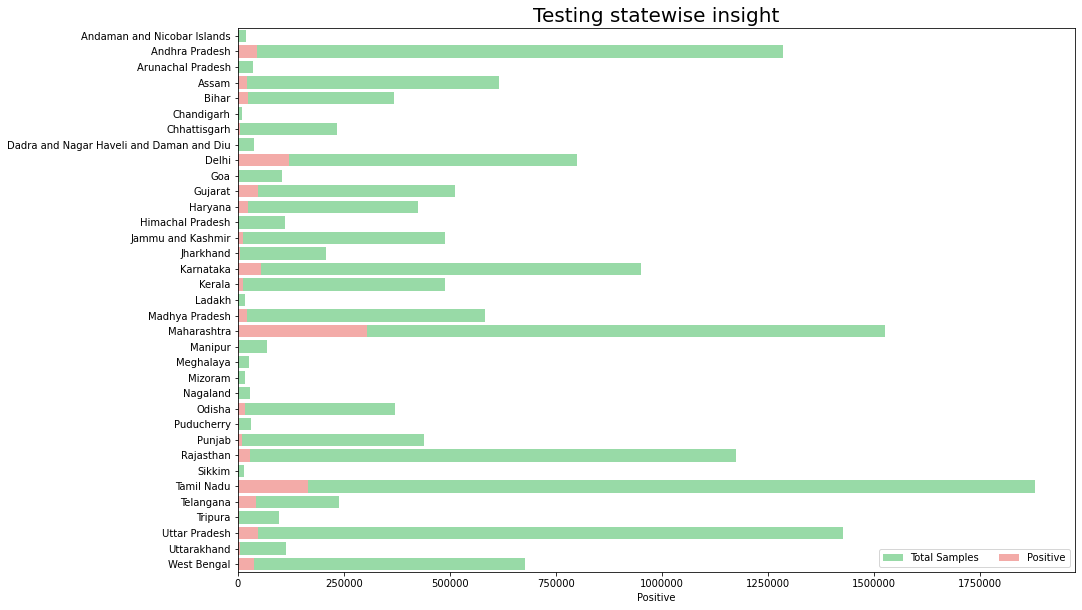

In [107]:
state_test = pd.pivot_table(state_testing, values=['TotalSamples','Negative','Positive'], index='State', aggfunc='max')
state_names = list(state_test.index)
state_test['State'] = state_names

plt.figure(figsize=(15,10))

sns.barplot(x="TotalSamples", y= state_names, data=state_test,label="Total Samples", color = 'g')

sns.barplot(x='Positive', y=state_names, data=state_test,label='Positive', color='r')
plt.title('Testing statewise insight',fontsize = 20)
plt.ticklabel_format(style='plain' , axis='x')
plt.legend(ncol=2, loc="lower right", frameon=True);

## Prediction

#####  Prediction using growth factor  
Assuming the same growth factor continues for the next 15 days


In [98]:
df1 = confirmed_df.groupby('Country/Region').sum().reset_index()
df2 = deaths_df.groupby('Country/Region').sum().reset_index()
df3 = recovered_df.groupby('Country/Region').sum().reset_index()

k =df1[df1['Country/Region']=='India'].loc[:,'2/4/20':]
india_confirmed = k.values.tolist()[0] 

growth_diff = []

for i in range(1,len(india_confirmed)):
    growth_diff.append(india_confirmed[i] / india_confirmed[i-1])

growth_factor = sum(growth_diff)/len(growth_diff)
print('Average growth factor',growth_factor)

Average growth factor 1.0969976172394946


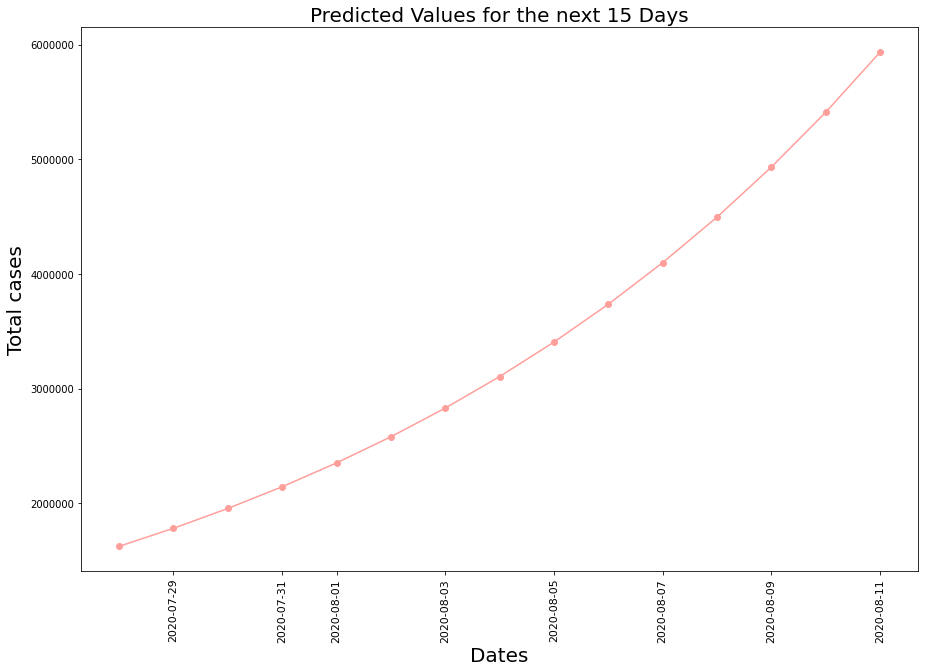

In [108]:
prediction_dates = []

start_date = dates_india[len(dates_india) - 1]
for i in range(15):
    date = start_date + datetime.timedelta(days=1)
    prediction_dates.append(date)
    start_date = date
previous_day_cases = global_confirmed[5][len(dates_india) - 1]
predicted_cases = []

for i in range(15):
    predicted_value = previous_day_cases *  growth_factor
    predicted_cases.append(predicted_value)
    previous_day_cases = predicted_value

plt.figure(figsize= (15,10))
plt.xticks(rotation = 90 ,fontsize = 11)
plt.yticks(fontsize = 10)
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Predicted Values for the next 15 Days" , fontsize = 20)
plt.ticklabel_format(style='plain' , axis='y')
ax1 = plt.plot_date(y= predicted_cases,x= prediction_dates,linestyle ='-',color = 'r')

We could see that the graph is increasing exponentialy if the average growth factor doesn't decrease. It is important that the growth factor is reduced to flatten the curve.

In [112]:
k = df1[df1['Country/Region']=='India'].loc[:,'1/22/20':]
india_confirmed = k.values.tolist()[0] 
data = pd.DataFrame(columns = ['ds','y'])
data['ds'] = dates
data['y'] = india_confirmed


### Arima Prediction

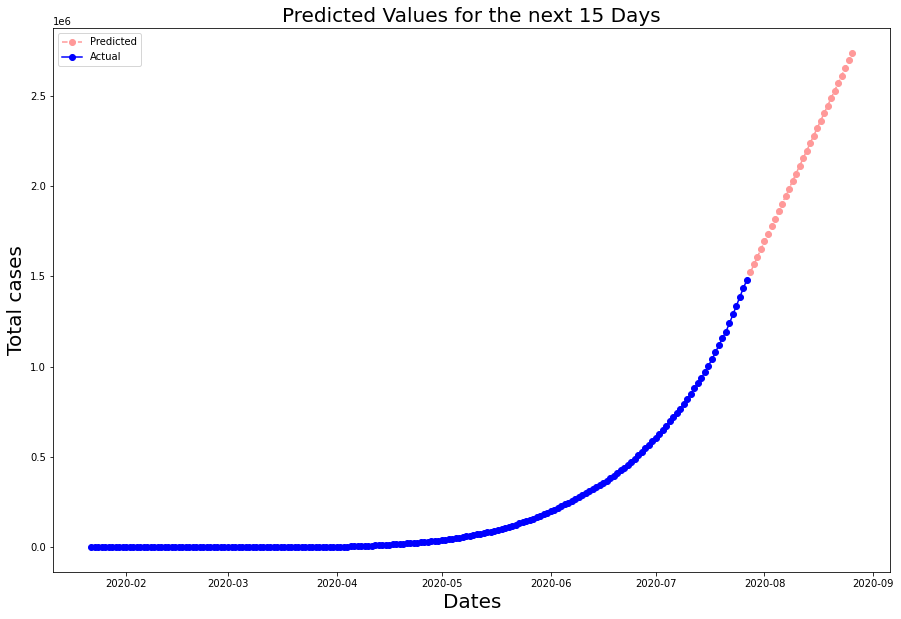

In [113]:
arima = ARIMA(data['y'], order=(5, 1, 0))
arima = arima.fit(trend='c', full_output=True, disp=True)
forecast = arima.forecast(steps= 30)
pred = list(forecast[0])

start_date = data['ds'].max()
prediction_dates = []
for i in range(30):
    date = start_date + datetime.timedelta(days=1)
    prediction_dates.append(date)
    start_date = date
plt.figure(figsize= (15,10))
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Predicted Values for the next 15 Days" , fontsize = 20)

plt.plot_date(y= pred,x= prediction_dates,linestyle ='dashed',color = '#ff9999',label = 'Predicted');
plt.plot_date(y=data['y'],x=data['ds'],linestyle = '-',color = 'blue',label = 'Actual');
plt.legend();

### Prediction using Prophet Model

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


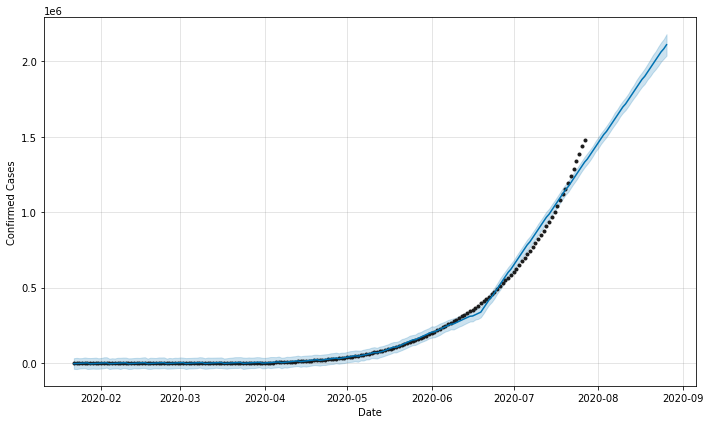

In [114]:
prop=Prophet()
prop.fit(data)
future=prop.make_future_dataframe(periods=30)
prop_forecast=prop.predict(future)
forecast = prop_forecast[['ds','yhat']].tail(30)

fig = plot_plotly(prop, prop_forecast)
fig = prop.plot(prop_forecast,xlabel='Date',ylabel='Confirmed Cases')

#### Acknowledgements
Thanks to Indian Ministry of Health & Family Welfare for making the data available to general public.

Thanks to covid19india.org for making the individual level details and testing details available to general public.